In [64]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [65]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup')
images_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/img')

In [66]:
# What type of data do we want?
fs_var = 'ThickAvg'     #["ThickAvg", "ThickStd", "SurfArea", "GrayVol", "ICVol", "ICMean", "ICStd"]
transformation = 'no'   #['no', 'zscore', 'scale']

In [67]:
# Create the directory with results
nm_dir = os.path.join(models_dir, fs_var+'_'+transformation)
os.makedirs(nm_dir, exist_ok=True)

# Load the appropriate data
if 'IC' in fs_var:
    data_final = pd.read_csv(os.path.join(bdata_dir, 'all_data_ThickAvg.txt'), sep=' ', index_col=0)
else:
    data_final = pd.read_csv(os.path.join(bdata_dir, 'all_data_'+fs_var+'.txt'), sep=' ', index_col=0)


In [68]:
# Prepare the data 
cov_norm, cov_pat, feat_norm, feat_pat = prepare_data(data_final, transformation, nm_dir, features=fs_var)

No transformation was applied


In [69]:
# Train the model
os.chdir(nm_dir)
if not os.path.isfile(os.path.join(nm_dir,'Z_estimate.txt')): 
    pcn.normative.estimate(covfile = os.path.join(nm_dir,'cov_norm.txt'),
                        respfile = os.path.join(nm_dir,'feat_norm.txt'),
                        cvfolds = 10,
                        alg = 'gpr') #outputsuffix = '_10fold'

Text(0.5, 0.98, 'ThickAvg no')

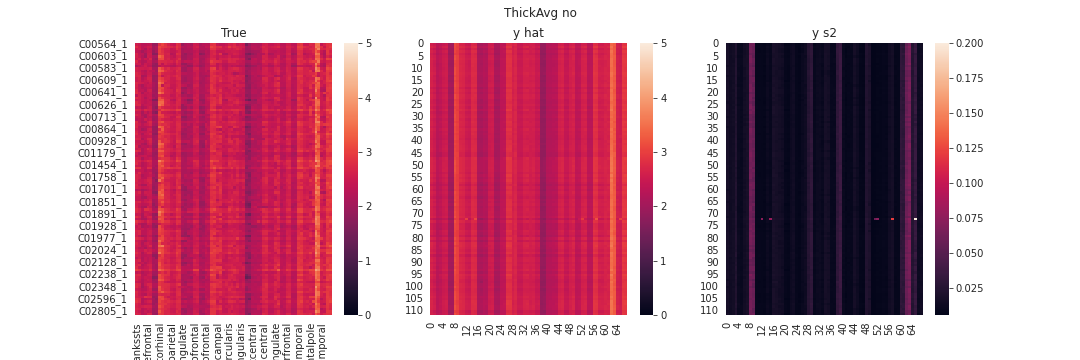

In [70]:
yhat = pd.read_csv(os.path.join(nm_dir,'yhat_estimate.txt'), sep=' ', header=None)
ys2 = pd.read_csv(os.path.join(nm_dir,'ys2_estimate.txt'), sep=' ', header=None)

rtop = np.ceil(np.max([feat_norm.max().max(),yhat.max().max()]))

fig, axes = plt.subplots(1,3,figsize=(15, 5))
sns.heatmap(data=feat_norm, ax=axes[0], cbar=True, cmap='rocket', vmin=0, vmax=rtop)
axes[0].set_title('True')
sns.heatmap(data=yhat, ax=axes[1], cbar=True, cmap='rocket', vmin=0, vmax=rtop)
axes[1].set_title('y hat')
sns.heatmap(data=ys2, ax=axes[2], cbar=True, cmap='rocket')
axes[2].set_title('y s2')
fig.suptitle(fs_var + ' ' + transformation)

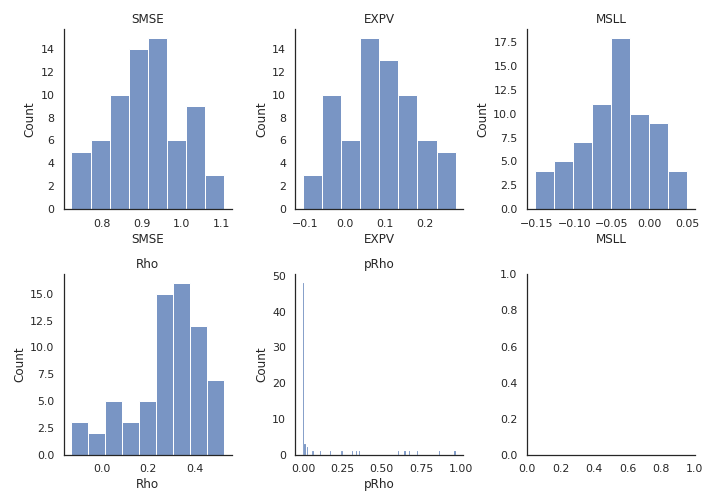

In [71]:
# Load and plot quality measures
nmeasures = plot_quality(nm_dir)

In [72]:
## Create forward model to get the centiles 
os.chdir(nm_dir)
cov_forw = {'Age_at_Visit': [20, 30, 40, 50,
                            20, 30, 40, 50],
            'Sex' :         [0,0,0,0,
                            1,1,1,1]}
cov_forw = pd.DataFrame(data=cov_forw)                            
cov_forw.to_csv(os.path.join(nm_dir, 'cov_forw.txt'), sep=' ', header=False, index=False)

# estimate
os.chdir(nm_dir)
if not os.path.isfile(os.path.join(nm_dir,'ys2_forward.txt')): 
    pcn.normative.estimate(covfile='cov_norm.txt',
                            respfile='feat_norm.txt',
                            testcov='cov_forw.txt',
                            cvfolds=None,
                            alg='gpr',
                            outputsuffix='_forward')

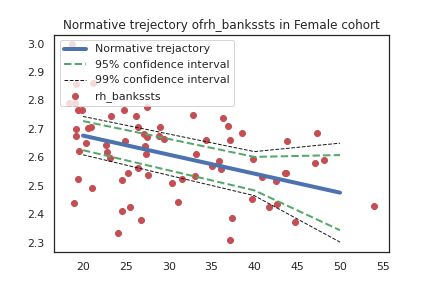

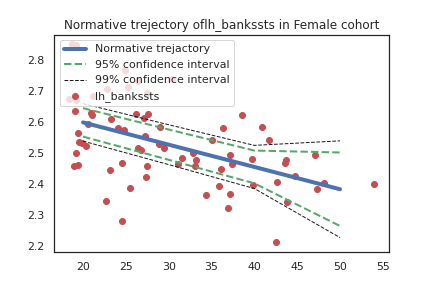

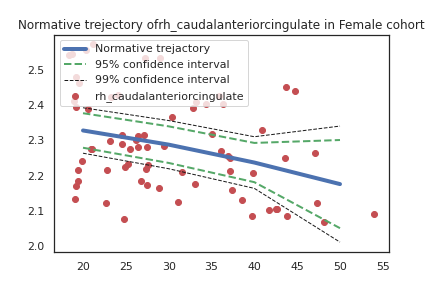

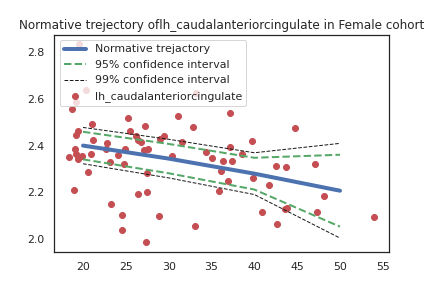

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


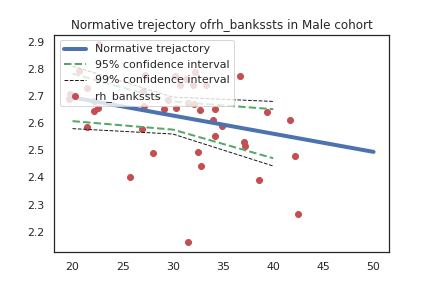

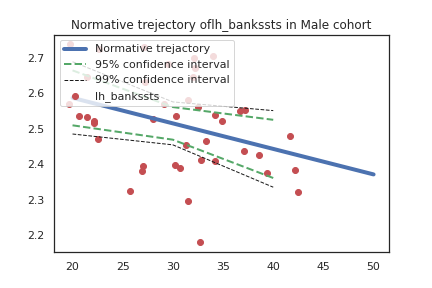

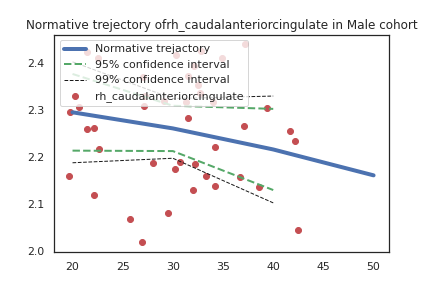

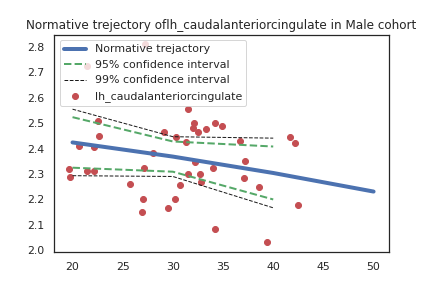

In [214]:
# plot a few regions with trajectories
trajectory_plotting(cov_forw, nm_dir)

In [10]:
# apply normative modeling to Patients
pcn.normative.estimate(covfile = 'cov_norm.txt',
                       respfile = 'feat_norm.txt',
                       testcov = 'cov_test.txt',
                       testresp = 'feat_test.txt',
                       cvfolds = None,
                       alg = 'gpr',
                       outputsuffix = '_test',
                       param_inscale = None,
                       param_outscale = None)

Processing data in feat_norm.txt
Estimating model  1 of 68
Optimization terminated successfully.
         Current function value: -55.310230
         Iterations: 50
         Function evaluations: 101
         Gradient evaluations: 101
Estimating model  2 of 68
Optimization terminated successfully.
         Current function value: -67.544781
         Iterations: 46
         Function evaluations: 100
         Gradient evaluations: 100
Estimating model  3 of 68
Optimization terminated successfully.
         Current function value: -61.691640
         Iterations: 51
         Function evaluations: 107
         Gradient evaluations: 107
Estimating model  4 of 68
Optimization terminated successfully.
         Current function value: -40.122368
         Iterations: 46
         Function evaluations: 111
         Gradient evaluations: 111
Estimating model  5 of 68
Optimization terminated successfully.
         Current function value: -78.657095
         Iterations: 46
         Function evaluatio

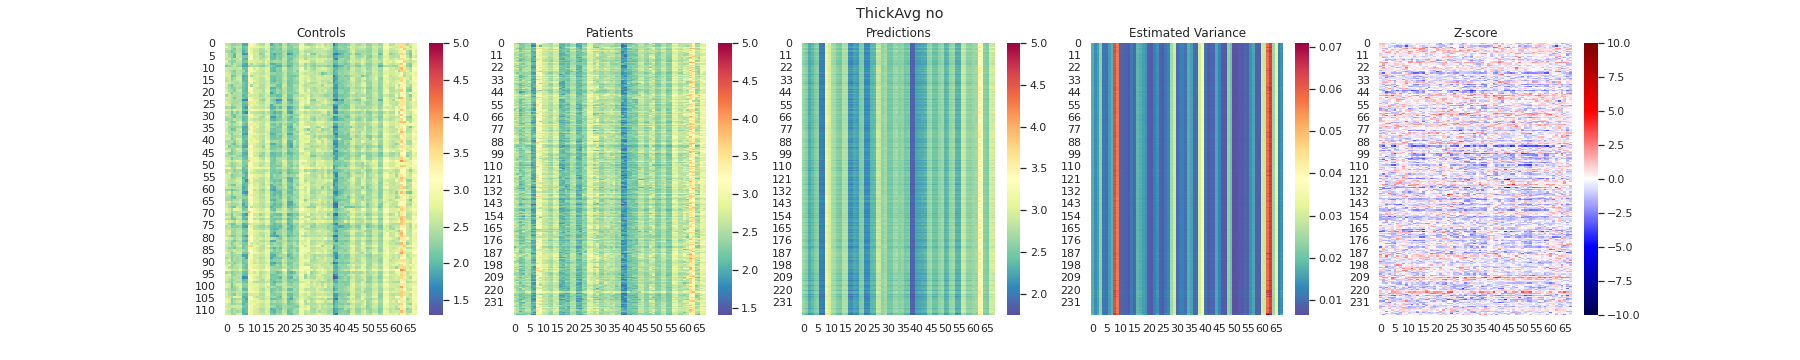

In [73]:
# Plot real and predicted values and estimated variance of the prediction
sns.set_style("white")
feat_norm = pd.read_csv(os.path.join(nm_dir,'feat_norm.txt'), sep=' ', header=None)
feat_test = pd.read_csv(os.path.join(nm_dir,'feat_test.txt'), sep=' ', header=None)
yhat_test = pd.read_csv(os.path.join(nm_dir,'yhat_test.txt'), sep=' ', header=None)
ys2_test = pd.read_csv(os.path.join(nm_dir,'ys2_test.txt'), sep=' ', header=None)
z_test = pd.read_csv(os.path.join(nm_dir,'Z_test.txt'), sep=' ', header=None)

#yhat = pd.read_csv(os.path.join(nm_dir,'yhat_10foldscale.txt'), sep=' ', header=None)
#ys2 = pd.read_csv(os.path.join(nm_dir,'ys2_10foldscale.txt'), sep=' ', header=None)

rtop = np.ceil(np.max([feat_norm.max().max(),yhat.max().max()]))

fig, axes = plt.subplots(1,5,figsize=(25, 5))

sns.heatmap(data=feat_norm, ax=axes[0], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[0].set_title('Controls')
sns.heatmap(data=feat_test, ax=axes[1], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[1].set_title('Patients')
sns.heatmap(data=yhat_test, ax=axes[2], cbar=True, cmap='Spectral_r', vmax=rtop)
axes[2].set_title('Predictions')
sns.heatmap(data=ys2_test, ax=axes[3], cbar=True, cmap='Spectral_r')
axes[3].set_title('Estimated Variance')
sns.heatmap(data=z_test, ax=axes[4], vmax=10, vmin = -10, cbar=True, cmap='seismic')
axes[4].set_title('Z-score')

fig.suptitle(fs_var + ' ' + transformation)

plt.show()

Text(0.5, 1.0, 'Positive')

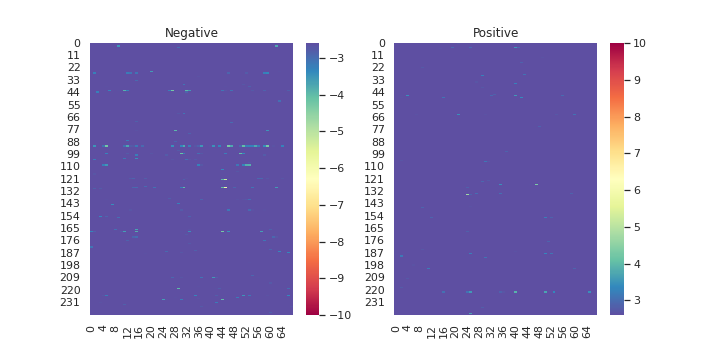

In [74]:
fig, axes = plt.subplots(1,2,figsize=(10, 5))

sns.heatmap(data=z_test, ax=axes[0], cbar=True, cmap='Spectral',  vmax=-2.6, vmin= -10) #z: 2.6 == p:0.005
axes[0].set_title('Negative')
sns.heatmap(data=z_test, ax=axes[1], cbar=True, cmap='Spectral_r', vmin = 2.6, vmax = 10)
axes[1].set_title('Positive')



In [10]:
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

In [75]:
cnames = pd.read_csv(os.path.join(nm_dir,'colnames.txt'), sep = ' ',header=None).to_numpy()
cnames = [i[0] for i in cnames]
cnames = [i.replace('rh_','R_') for i in cnames]
cnames = [i.replace('lh_','L_') for i in cnames]
z_test.columns = cnames

In [144]:
R_hemi = [col for col in z_test.columns if 'R_' in col]
L_hemi = [col for col in z_test.columns if 'L_' in col]
z_test = pd.concat([z_test[L_hemi], z_test[R_hemi]], axis=1)

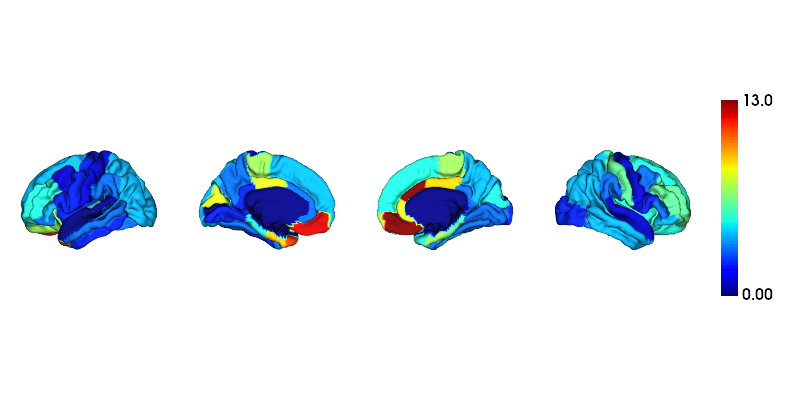

In [212]:
z_epoz = (z_test>2).sum()

#CT_d_fsa5 = parcel_to_surface(z_test, 'aparc_fsa5')
CT_z_mean_fsa5 = parcel_to_surface(z_epoz, 'aparc_fsa5')

plot_cortical(array_name=CT_z_mean_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='jet', color_bar=True,
              interactive=False,
              embed_nb=True,
              screenshot=False,
              filename=None)

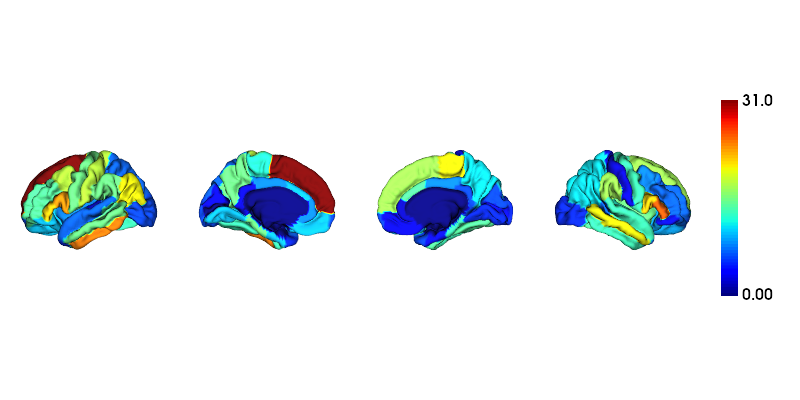

In [213]:
z_eneg = (z_test<-2).sum()

#CT_d_fsa5 = parcel_to_surface(z_test, 'aparc_fsa5')
CT_z_mean_fsa5 = parcel_to_surface(z_eneg, 'aparc_fsa5')

plot_cortical(array_name=CT_z_mean_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='jet', color_bar=True,
              interactive=False,
              embed_nb=True,
              screenshot=False,
              filename=None)

In [202]:
# Checking, whether the atlas sworks fine

#pk = np.zeros(68)
#pk[20] = 1
#pk[[27,28,29,30]] = [100,300,1000,1500]
#pk = pk[np.newaxis,:]
#pk = pd.DataFrame(pk,columns = z_test.columns)
#z_test2 = z_test
#z_test2 = z_test2.append(pk)

In [204]:
#CT_d_fsa5 = parcel_to_surface(z_test, 'aparc_fsa5')
CT_z_mean_fsa5 = parcel_to_surface(z_test.iloc[-1,:], 'aparc_fsa5')


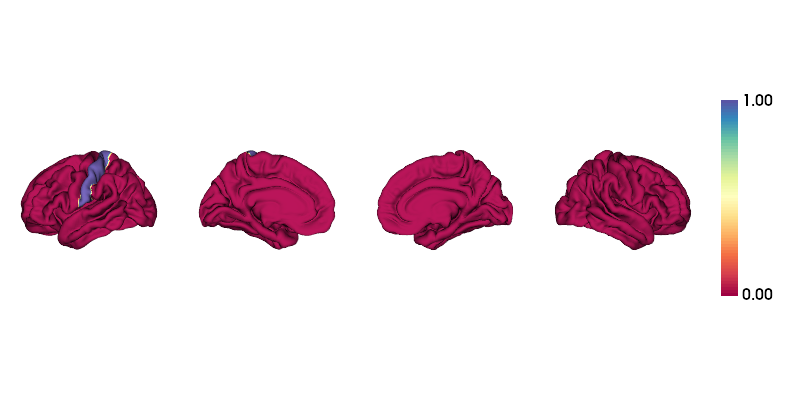

In [205]:
plot_cortical(array_name=CT_z_mean_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='Spectral', color_bar=True,
              interactive=False,
              embed_nb=True,
              screenshot=False,
              filename=None)

In [38]:
cnames = pd.read_csv(os.path.join(nm_dir,'colnames.txt'), sep = ' ',header=None).to_numpy()
cnames = [i[0] for i in cnames]
cnames = [i.split('_')[1] for i in cnames]
z_test.columns = cnames

# This is for vizualization of Desikan Killiany intracranial volumes
int_dict = {'Left-Lateral-Ventricle': 'LLateVent',
        'Left-Thalamus': 'Lthal',
        'Left-Caudate': 'Lcaud',
        'Left-Putamen': 'Lput',
        'Left-Pallidum': 'Lpal',
        'Left-Hippocampus': 'Lhippo',
        'Left-Amygdala': 'Lamyg',
        'Left-Accumbens-area': 'Laccumb',
        'Right-Lateral-Ventricle': 'RLatVent',
        'Right-Thalamus': 'Rthal',
        'Right-Caudate': 'Rcaud',
        'Right-Putamen': 'Rput',
        'Right-Pallidum': 'Rpal',
        'Right-Hippocampus': 'Rhippo',
        'Right-Amygdala': 'Ramyg',
        'Right-Accumbens-area': 'Raccumb'
 }

z_test.rename(columns=int_dict, inplace=True)
z_pk = z_test.iloc[:,[0,4,5,6,7,11,12,14,18,22,23,24,25,26,27,28]]
z_reorder = reorder_sctx(z_pk)

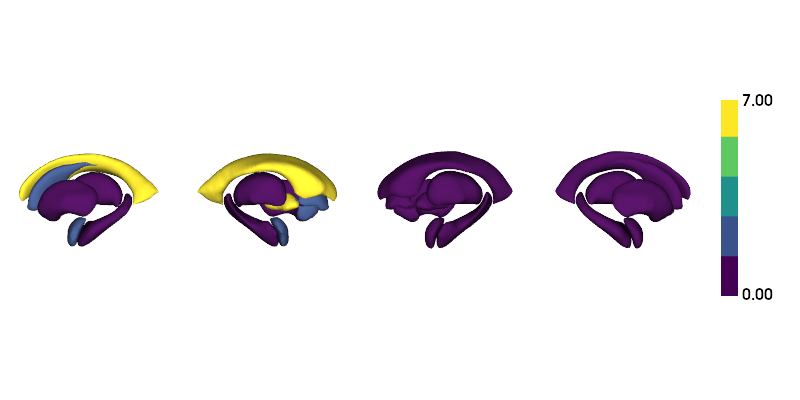

In [62]:
z_epoz = (z_reorder>2.6).sum()

# This is for vizualization of Desikan Killiany intracranial volumes
plot_subcortical(array_name=z_epoz, size=(800, 400),
                 cmap='viridis', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=False,
                 filename=None,
                 background=(1,1,1))            

In [63]:
print('The highest number of extreme positive deviations is:' + str(z_eneg.max()))            

The highest number of extreme positive deviations is:7


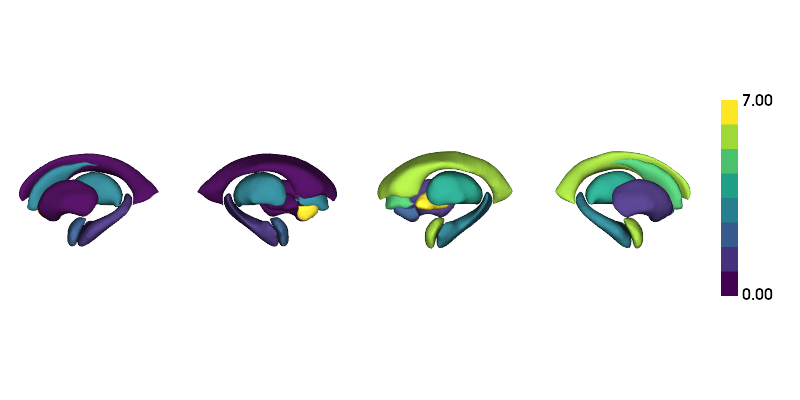

In [60]:
z_eneg = (z_reorder<-2.6).sum()

# This is for vizualization of Desikan Killiany intracranial volumes
plot_subcortical(array_name=z_eneg, size=(800, 400),
                 cmap='viridis', color_bar=True,
                 interactive=False,
                 embed_nb=True,
                 screenshot=False,
                 filename=None,
                 background=(1,1,1))            

In [61]:
print('The highest number of extreme negative deviations is:' + str(z_eneg.max()))            

The highest number of extreme negative deviations is:7


In [131]:
from enigmatoolbox.datasets import load_example_data

cov, metr1_SubVol, metr2_CortThick, metr3_CortSurf = load_example_data()

In [169]:
metr3_CortSurf.columns

Index(['SubjID', 'L_bankssts_surfavg', 'L_caudalanteriorcingulate_surfavg',
       'L_caudalmiddlefrontal_surfavg', 'L_cuneus_surfavg',
       'L_entorhinal_surfavg', 'L_fusiform_surfavg',
       'L_inferiorparietal_surfavg', 'L_inferiortemporal_surfavg',
       'L_isthmuscingulate_surfavg', 'L_lateraloccipital_surfavg',
       'L_lateralorbitofrontal_surfavg', 'L_lingual_surfavg',
       'L_medialorbitofrontal_surfavg', 'L_middletemporal_surfavg',
       'L_parahippocampal_surfavg', 'L_paracentral_surfavg',
       'L_parsopercularis_surfavg', 'L_parsorbitalis_surfavg',
       'L_parstriangularis_surfavg', 'L_pericalcarine_surfavg',
       'L_postcentral_surfavg', 'L_posteriorcingulate_surfavg',
       'L_precentral_surfavg', 'L_precuneus_surfavg',
       'L_rostralanteriorcingulate_surfavg', 'L_rostralmiddlefrontal_surfavg',
       'L_superiorfrontal_surfavg', 'L_superiorparietal_surfavg',
       'L_superiortemporal_surfavg', 'L_supramarginal_surfavg',
       'L_frontalpole_surfavg', 